## Are the music genres similar between friends? (Part 1)

In this project, I'd like to explore the songs in me and my friend Cindy's Spotify playlists.<br>
Cindy and I have been close friends since college. I know that she mainly listens to Japanese songs, but I prefer English songs.<br>
My guessing is that our music tastes are very different.<br>

I fetched our playlists using Spotify API.<br>
Let's try to answer the question: **Are the music genres similar between friends?**
<br>

This project is divided into two parts, presented by two notebooks, this is notebook 1, which contains the following steps:
1. **Data cleaning** (check for variable types, missing data, duplicates in each user's playlist)
2. **Normalization** before drawing the histogram
3. **Data visualization** (histograms, bar plots)
4. Find repeated songs in both playlists
5. **Correlation** between each variables
<br>

In notebook 2, we'll try to build a model to predict which user a song should belong to, which contains the following steps:
1. **Feature engineering** (standardization)
2. **Logistic regression** model
3. **Random forest** classifier
4. **Hyperparameters tuning**
5. Conclusions

### 1. Data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import data (Spotify playlists of two different users)
UserA = pd.read_csv("fm12z8ig3mo6s9axre6049m5h-1vgZmbngUv9YFEsz3AB18e.csv") # Me (Connie)
UserB = pd.read_csv("21hi7kguws4venzuqvqs4lska-6KeEoUTI2bbmOoK7McTrLF.csv") # My friend Cindy

a = len(UserA)
b = len(UserB)

print(a,b)

561 1290


In [3]:
UserA.dtypes

energy              float64
liveness            float64
tempo               float64
speechiness         float64
acousticness        float64
instrumentalness    float64
time_signature        int64
danceability        float64
key                   int64
duration_ms           int64
loudness            float64
valence             float64
mode                  int64
type                 object
uri                  object
dtype: object

In [4]:
UserA.columns

Index(['energy', 'liveness', 'tempo', 'speechiness', 'acousticness',
       'instrumentalness', 'time_signature', 'danceability', 'key',
       'duration_ms', 'loudness', 'valence', 'mode', 'type', 'uri'],
      dtype='object')

In [5]:
UserA.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,0.565125,0.162255,123.297893,0.052862,0.374275,0.019927,3.953654,0.578889,5.377897,235481.101604,-7.266465,0.417384,0.770053
std,0.200585,0.121400,29.145264,0.046102,0.304508,0.118239,0.295185,0.138681,3.525389,43385.776300,3.388694,0.207114,0.421174
min,0.020700,0.029000,46.168000,0.023200,0.001030,0.000000,1.000000,0.130000,0.000000,100787.000000,-34.218000,0.030500,0.000000
25%,0.425000,0.095100,99.946000,0.031200,0.076700,0.000000,4.000000,0.493000,2.000000,202326.000000,-8.543000,0.246000,1.000000
50%,0.567000,0.116000,123.949000,0.037800,0.309000,0.000000,4.000000,0.573000,5.000000,232853.000000,-6.690000,0.383000,1.000000
75%,0.728000,0.171000,141.284000,0.054100,0.643000,0.000006,4.000000,0.684000,9.000000,264307.000000,-5.065000,0.558000,1.000000
max,0.963000,0.948000,210.534000,0.463000,0.980000,0.978000,5.000000,0.878000,11.000000,484147.000000,-1.573000,0.953000,1.000000


In [6]:
# Check for missing
UserA.isna().sum()

energy              0
liveness            0
tempo               0
speechiness         0
acousticness        0
instrumentalness    0
time_signature      0
danceability        0
key                 0
duration_ms         0
loudness            0
valence             0
mode                0
type                0
uri                 0
dtype: int64

In [7]:
UserB.isna().sum()

energy              0
liveness            0
tempo               0
speechiness         0
acousticness        0
instrumentalness    0
time_signature      0
danceability        0
key                 0
duration_ms         0
loudness            0
valence             0
mode                0
type                0
uri                 0
dtype: int64

In [8]:
# Check duplicates
dupA = UserA.drop_duplicates().reset_index(drop=True)
print(len(UserA), len(dupA))

561 561


In [9]:
dupB = UserB.drop_duplicates().reset_index(drop=True)
print(len(UserB), len(dupB))

1290 1289


### What do we know about our data?

#### The following are the audio features of songs:
* **danceability**: how suitable the track is for dancing, 0(not danceable)->1(very danceable)
* **energy**: how energetic the track is, 0(less energetic)->1(very energetic)
* **key**: the major key of the track, 0:C, 1:C#, 2:D, ..., 11:B
* **loudness**: how loud the song is in dB -60(very quiet)->0(very loud)
* **mode**: whether the track is major (1) or minor (0)
* **speechiness**: the ratio of spoken words to the overall, 0(instrumental)->1(talk show)
* **acousticness**: whether the song is acoustic or not, 0(not acoustic)->1(very acoustic)
* **instrumentalness**: the ratio of instrumental sounds overall, 0(lot of vocal sounds)->1(instrument sounds)
* **liveness**: presence of audience, 0(studio record)->1(concert)
* **valence**: how positive the music is, 0(sad)->1(cheerful)
* **tempo**: tempo of track in BPM
* **time_signature**: the predicted time signature of the track, most typically 4
<br>

* ref: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=tracks.csv

I decided to normalize **tempo** and **loudness** to have consistency in the scale of the histogram.

### 2. Normalization

In [10]:
def normalization(indata, username):
    from sklearn.preprocessing import MinMaxScaler
    features = ['tempo', 'loudness']
    min_max_scaler = MinMaxScaler()
    x = indata[features]
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=x.columns)
    df[list(indata.drop(features, axis=1).columns)] = indata[list(indata.drop(features, axis=1).columns)]
    #indata['tempo', 'loudness']=(df-df.min())/(df.max()-df.min())
    print(df.isna().sum())
    df.to_csv('{}.csv'.format(username), index=False)

In [11]:
normalization(indata=dupA, username='Connie')

tempo               0
loudness            0
energy              0
liveness            0
speechiness         0
acousticness        0
instrumentalness    0
time_signature      0
danceability        0
key                 0
duration_ms         0
valence             0
mode                0
type                0
uri                 0
dtype: int64


In [12]:
normalization(indata=dupB, username='Cindy')

tempo               0
loudness            0
energy              0
liveness            0
speechiness         0
acousticness        0
instrumentalness    0
time_signature      0
danceability        0
key                 0
duration_ms         0
valence             0
mode                0
type                0
uri                 0
dtype: int64


In [13]:
AA = pd.read_csv('Connie.csv')
BB = pd.read_csv('Cindy.csv')
AA.head()

,tempo,loudness,energy,liveness,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,valence,mode,type,uri
0,0.437578,0.905897,0.825,0.0936,0.0325,0.02150,0.000024,4,0.650,0,191014,0.593,1,audio_features,spotify:track:37BZB0z9T8Xu7U3e65qxFy
1,0.364047,0.915117,0.864,0.0389,0.0652,0.00327,0.000000,4,0.697,10,199013,0.808,1,audio_features,spotify:track:2SIKHGA7vsLF2zUiqjEh4x
2,0.692400,0.932608,0.715,0.2880,0.0636,0.34700,0.013600,4,0.559,5,198210,0.335,1,audio_features,spotify:track:1FDGTwqfK4mmwFZOd7qn5H
3,0.589057,0.847450,0.706,0.0640,0.1600,0.22300,0.000280,4,0.766,7,172598,0.766,0,audio_features,spotify:track:18XlJEroUwFo0tLZxscgXE
4,0.290942,0.869904,0.560,0.1090,0.0288,0.14800,0.000015,4,0.626,0,244005,0.229,0,audio_features,spotify:track:2d1MywHy6FwKdzxFuSJnwl


### 3. Data visualization

### 3-1. Histograms: a quick view of the distribution of audio features

In [14]:
var_drop_hist = ['mode', 'key', 'time_signature', 'duration_ms']
def audio_feature(df, col, user):
    fig,axes = plt.subplots(3,3)
    df.drop(var_drop_hist, axis=1).plot.hist(figsize=(15, 10), bins=10, subplots=True, ax=axes, legend=False, color=col)

    axes[0,0].set_title('tempo')
    axes[0,1].set_title('loudness')
    axes[0,2].set_title('energy')
    axes[1,0].set_title('liveness')
    axes[1,1].set_title('speechiness')
    axes[1,2].set_title('acousticness')
    axes[2,0].set_title('instrumentalness')
    axes[2,1].set_title('danceability')
    axes[2,2].set_title('valence')

    plt.suptitle('The distributions of audio features in {}\'s playlist'.format(user))
    plt.tight_layout()
    plt.show()   

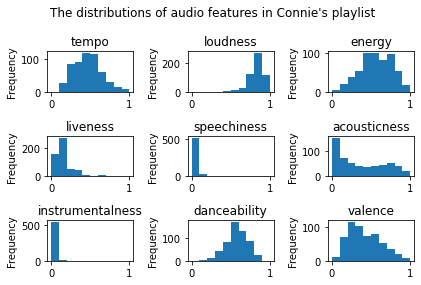

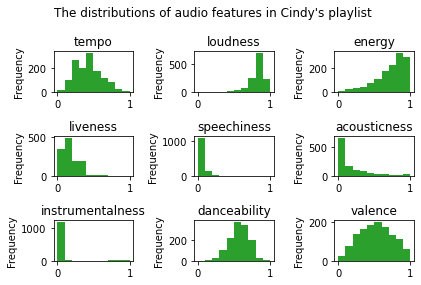

In [15]:
audio_feature(df=AA, col=u'#1f77b4', user='Connie')
audio_feature(df=BB, col=u'#2ca02c', user='Cindy')

**Following are the interesting findings after plotting the histogram:**
1. The distributions of audio features are skewed, we should check on medians rather than means.
2. The distribution of **energy** and **valence** showed a greater difference. Cindy's playlist seemed to contain rather more positive, energetic songs.
3. There is also a slightly different in the distribution of **acousticness**.

### 3-2. Bar plots

In [16]:
def audio_feature_median(df, col, user):
    T = df.drop(var_drop_hist, axis=1).describe().T
    T.sort_values(by=['50%'], ascending=False, na_position='first', inplace=True)
    x = np.arange(len(T.index))
    y = T['50%']
    plt.bar(x, y, color=col) # color=['red', 'green', 'blue', 'yellow']
    plt.xticks(x, T.index, rotation=320, ha='left') # ha = orizontal alignment, ['left', 'center', 'right']
    plt.xlabel('Features')
    plt.ylabel('Median')
    plt.title('Median of the audio features in {}\'s playlist'.format(user))
    plt.show()

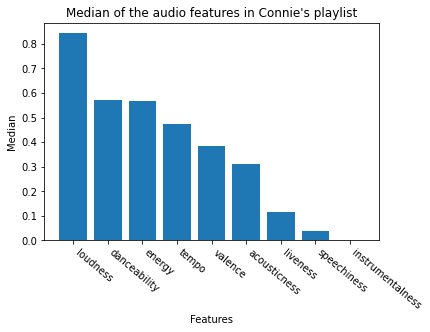

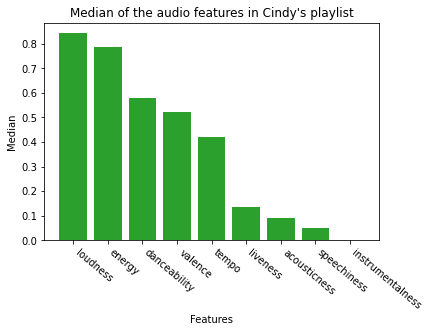

In [17]:
audio_feature_median(df=AA, col=u'#1f77b4', user='Connie')
audio_feature_median(df=BB, col=u'#2ca02c', user='Cindy')

From the above plots we can see that, in general, we both like songs with more vitality!

In [18]:
# Difference between audio features median
A_sum = AA.drop(var_drop_hist, axis=1).describe().T.rename(columns={'50%':'median'}).drop(['count', 'min', '25%', '75%', 'max'], axis=1)
A_sum.columns = ['a_' + str(col) for col in A_sum.columns]

B_sum = BB.drop(var_drop_hist, axis=1).describe().T.rename(columns={'50%':'median'}).drop(['count', 'min', '25%', '75%', 'max'], axis=1)
B_sum.columns = ['b_' + str(col) for col in B_sum.columns]

# Place the DataFrames side by side
SUM = pd.concat([A_sum, B_sum], axis=1)
SUM

,a_mean,a_std,a_median,b_mean,b_std,b_median
tempo,0.469257,0.177319,0.473218,0.423631,0.178164,0.419601
loudness,0.825595,0.103804,0.843253,0.821454,0.105359,0.842116
energy,0.565125,0.200585,0.567000,0.733696,0.200555,0.788000
liveness,0.162255,0.121400,0.116000,0.187419,0.136204,0.134000
speechiness,0.052862,0.046102,0.037800,0.066931,0.052493,0.048600
acousticness,0.374275,0.304508,0.309000,0.201912,0.252685,0.091300
instrumentalness,0.019927,0.118239,0.000000,0.046328,0.174015,0.000003
danceability,0.578889,0.138681,0.573000,0.572694,0.132287,0.579000
valence,0.417384,0.207114,0.383000,0.521602,0.226527,0.522000


In [19]:
# Difference between audio features median
SUM['D_ab'] = SUM['a_median'] - SUM['b_median']
SUM

,a_mean,a_std,a_median,b_mean,b_std,b_median,D_ab
tempo,0.469257,0.177319,0.473218,0.423631,0.178164,0.419601,0.053618
loudness,0.825595,0.103804,0.843253,0.821454,0.105359,0.842116,0.001138
energy,0.565125,0.200585,0.567000,0.733696,0.200555,0.788000,-0.221000
liveness,0.162255,0.121400,0.116000,0.187419,0.136204,0.134000,-0.018000
speechiness,0.052862,0.046102,0.037800,0.066931,0.052493,0.048600,-0.010800
acousticness,0.374275,0.304508,0.309000,0.201912,0.252685,0.091300,0.217700
instrumentalness,0.019927,0.118239,0.000000,0.046328,0.174015,0.000003,-0.000003
danceability,0.578889,0.138681,0.573000,0.572694,0.132287,0.579000,-0.006000
valence,0.417384,0.207114,0.383000,0.521602,0.226527,0.522000,-0.139000


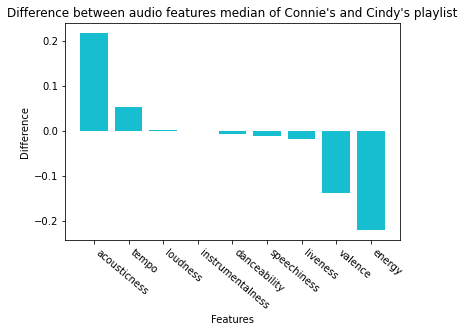

In [20]:
user1 = 'Connie'
user2 = 'Cindy'

# User1 - User2
SUM.sort_values(by=['D_ab'], ascending=False, na_position='first', inplace=True)
x = np.arange(len(SUM.index))
y = SUM['D_ab']
plt.bar(x, y, color=u'#17becf')
plt.xticks(x, SUM.index, rotation=320, ha='left')
plt.xlabel('Features')
plt.ylabel('Difference')
plt.title('Difference between audio features median of {}\'s and {}\'s playlist'.format(user1, user2))
plt.show()

The results in the above figure are consistent with our observations in the histogram.

In [21]:
# How varied is the playlist?
def audio_feature_sd(df, col, user):
    T = df.drop(var_drop_hist, axis=1).describe().T
    T.sort_values(by=['std'], ascending=False, na_position='first', inplace=True)
    x = np.arange(len(T.index))
    y = T['std']
    plt.bar(x, y, color=col)
    plt.xticks(x, T.index, rotation=320, ha='left')
    plt.xlabel('Features')
    plt.ylabel('Standard deviation')
    plt.title('Standard deviation of the audio features in {}\'s playlist'.format(user))
    plt.show()

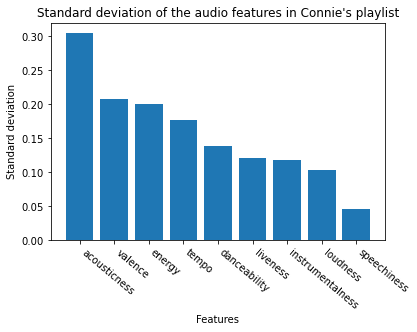

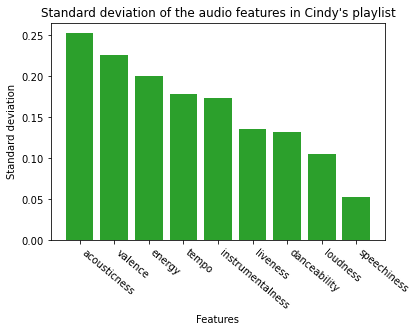

In [22]:
audio_feature_sd(df=AA, col=u'#1f77b4', user='Connie')
audio_feature_sd(df=BB, col=u'#2ca02c', user='Cindy')

In [23]:
# key & mode should be categorical data
AA[['key','mode']] = AA[['key','mode']].astype('object')
BB[['key','mode']] = BB[['key','mode']].astype('object')

In [24]:
AA.select_dtypes(include=object).columns

Index(['key', 'mode', 'type', 'uri'], dtype='object')

In [25]:
def bar_plot(df, var, col, user):
    variable = var
    cnt = pd.DataFrame(df[var].value_counts()).sort_index()
    fig, ax = plt.subplots()
    ax.bar(cnt.index, cnt[var], color=col)
    ax.set_xticks(cnt.index)
    ax.set(title='Distribution of the {} in {}\'s playlist'.format(variable, user), ylabel='counts');

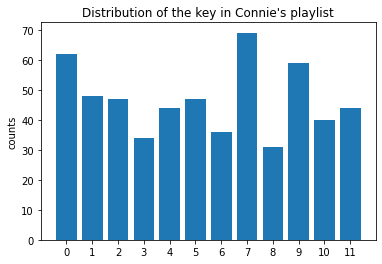

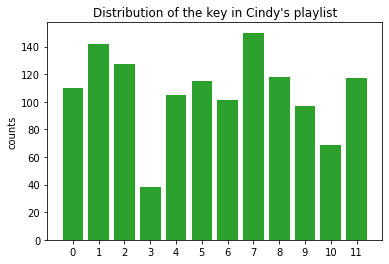

In [26]:
# Key: 0:C, 1:C#, 2:D, ..., 11:B
bar_plot(df=AA, var='key', col=u'#1f77b4', user='Connie')
bar_plot(df=BB, var='key', col=u'#2ca02c', user='Cindy')

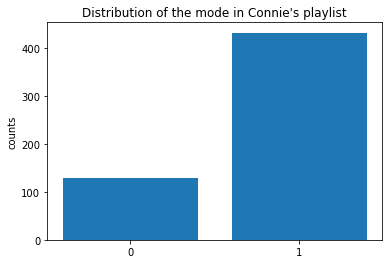

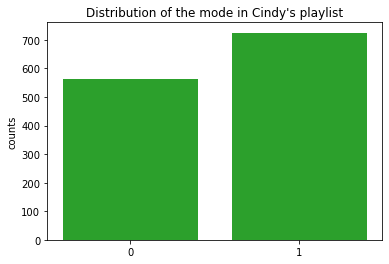

In [27]:
bar_plot(df=AA, var='mode', col=u'#1f77b4', user='Connie')
bar_plot(df=BB, var='mode', col=u'#2ca02c', user='Cindy')

### 4. Find repeated songs in both playlists

In [28]:
# Stack the DataFrames on top of each other
data = pd.concat([AA, BB], axis=0)

data.tail()

,tempo,loudness,energy,liveness,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,valence,mode,type,uri
1284,0.596122,0.770959,0.406,0.0710,0.0321,0.40200,0.000022,4,0.568,0,295333,0.337,1,audio_features,spotify:track:6lT0OjtvS7hhq7eIbytwm1
1285,0.327976,0.831636,0.848,0.0937,0.0343,0.07290,0.000004,4,0.680,0,317947,0.303,1,audio_features,spotify:track:3Ocobz1vRDS8TKljE0tc2U
1286,0.260730,0.844120,0.917,0.1140,0.0588,0.00923,0.000010,4,0.653,4,268480,0.627,0,audio_features,spotify:track:4ym75ZIcFGeL83SDozBBHd
1287,0.431756,0.769842,0.804,0.4140,0.0968,0.00486,0.000028,4,0.552,11,267120,0.543,0,audio_features,spotify:track:6zSXcvXQ8T74fXm72OpSOb
1288,0.521898,0.730815,0.300,0.0687,0.0291,0.01450,0.000000,4,0.567,11,268333,0.196,0,audio_features,spotify:track:2LYhS0VbCzbE6alAI3Q7Ot


In [29]:
len(data)

1850

In [30]:
check_dup = pd.DataFrame(data['uri'].value_counts())
len(check_dup[check_dup['uri']>1])

25

There are 25 repeated songs in our playlists.

In [31]:
# List the uri of the 25 duplicated songs
check_dup[check_dup['uri']>1]

,uri
spotify:track:1ZLrDPgR7mvuTco3rQK8Pk,2
spotify:track:6u4QtlkKJ879ElNlgw0R7M,2
spotify:track:0KWnRv3wxjltYVB3MqjNd2,2
spotify:track:76cy1WJvNGJTj78UqeA5zr,2
spotify:track:3CEkc8f1UDvI7kohz3ARpA,2
spotify:track:4wbiyZ6AsynnSNacGXmlvD,2
spotify:track:2h5j6lshsRkShTQ527SOlj,2
spotify:track:37sINbJZcFdHFAsVNsPq1i,2
spotify:track:4vUmTMuQqjdnvlZmAH61Qk,2
spotify:track:24nK8tW7Pt3Inh2utttuoG,2


### 5. Correlation between each variables

In [32]:
import seaborn as sns
# keep numeric variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
corr = data.select_dtypes(include=numerics).drop(['time_signature', 'duration_ms'], axis=1).corr()
corr

,tempo,loudness,energy,liveness,speechiness,acousticness,instrumentalness,danceability,valence
tempo,1.000000,0.078656,0.059193,0.032727,0.083276,-0.047520,-0.019643,-0.182620,0.045351
loudness,0.078656,1.000000,0.721606,0.092915,0.137329,-0.563459,-0.479365,0.195452,0.384984
energy,0.059193,0.721606,1.000000,0.168033,0.276861,-0.741513,-0.250443,0.104838,0.502988
liveness,0.032727,0.092915,0.168033,1.000000,0.079873,-0.107203,-0.042769,-0.072364,0.040320
speechiness,0.083276,0.137329,0.276861,0.079873,1.000000,-0.177658,-0.043204,0.008241,0.134062
acousticness,-0.047520,-0.563459,-0.741513,-0.107203,-0.177658,1.000000,0.254931,-0.108639,-0.348223
instrumentalness,-0.019643,-0.479365,-0.250443,-0.042769,-0.043204,0.254931,1.000000,-0.140213,-0.119381
danceability,-0.182620,0.195452,0.104838,-0.072364,0.008241,-0.108639,-0.140213,1.000000,0.448250
valence,0.045351,0.384984,0.502988,0.040320,0.134062,-0.348223,-0.119381,0.448250,1.000000


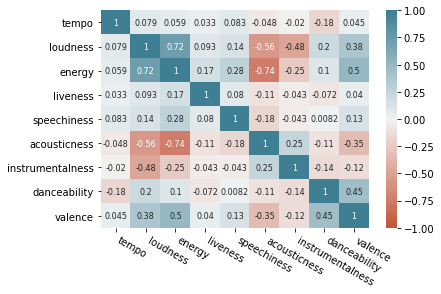

In [33]:
# Heatmap
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), #"RdBu_r"
    annot=True,
    annot_kws={'size':8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=330,
    horizontalalignment='left'
);

1. **loudness** is highly positively correlated to **energy**.
2. **acousticness** is highly negatively correlated to **energy**.